In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [3]:
def display_missed_predictions(y_pred, actual_y_value, predicted_y_value):
    misclassified = np.where(((y_test == actual_y_value) & (y_test != y_pred) & (y_pred == predicted_y_value)))
    list_of_misses = []
    for i in misclassified:
        for x in i:
            list_of_misses.append(x)
    if len(list_of_misses) == 0:
        return print("No missclassifications in this combination.")
        pass
    elif len(list_of_misses) == 1:
        missed = list_of_misses[0]
        pic = X_test[missed].reshape(28, 28)
        plt.imshow(pic)
        return 
    elif len(list_of_misses) % 2 == 0 and len(list_of_misses) != 1:
        tl = int(len(list_of_misses) / 2)
    else:
        tl = int((len(list_of_misses) + 1) / 2)
    numplots = 1
    for i in list_of_misses:
        pic = X_test[i].reshape(28, 28)
        plt.subplot(tl, tl, numplots)
        plt.imshow(pic)
        numplots += 1


In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data
y = mnist.target.astype(np.uint8)

c:\Users\olofs\anaconda3\envs\machine_learning\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


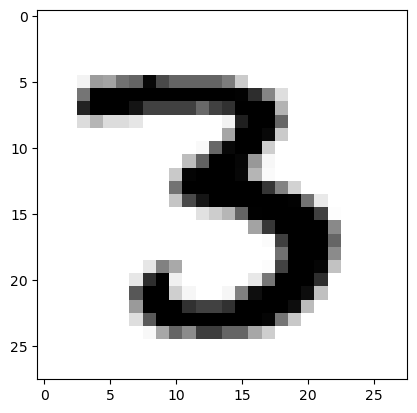

In [6]:
img = X[12].reshape(28, 28)
plt.imshow(img, cmap='binary')

In [7]:
y[12]

3

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


# Reduce dimensions to within a 98% accuracy

In [10]:
pca = PCA(n_components=0.98)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [45]:
print(X_train_reduced.shape)
print(X_test_reduced.shape)

(60000, 261)
(10000, 261)


# We now have 261 columns in X_train_reduced and X_test_reduced

# Let's train and predict using four different models with their default settings

In [46]:
kn_clf = KNeighborsClassifier()
log_reg_clf = LogisticRegression(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
svc_clf = SVC(random_state=42)

clf_list = []
pred_list = []
scores_list = []


for clf in (kn_clf, log_reg_clf, rf_clf, svc_clf):
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_test_reduced)
    pred_list.append(y_pred)
    score = accuracy_score(y_test, y_pred)
    clf_list.append(clf)
    scores_list.append(score)
    clf_name = type(clf).__name__
    pred_name = ('y_pred_' + clf_name)


c:\Users\olofs\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# We print the accuracy score of each to find the best one

In [47]:
for score, name in enumerate(clf_list):
    print(f"{name}: {scores_list[score]}")

KNeighborsClassifier(): 0.9694
LogisticRegression(random_state=42): 0.9217
RandomForestClassifier(random_state=42): 0.9434
SVC(random_state=42): 0.9829


In [48]:
# unpack the four results into variables for use later
y_pred_kn_clf, y_pred_log_reg_clf, y_pred_rf_clf, y_pred_svc_clf = pred_list[0:4]

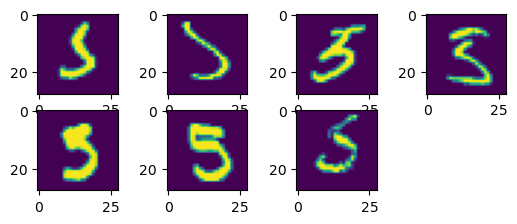

In [49]:
display_missed_predictions(y_pred_svc_clf, 5, 3)

# SVC performed best, try gridsearch


In [50]:
# Test SVC on a smaller dataset
X_train_svc, X_test_svc, y_train_svc, y_test_svc = X_train_reduced[:8000], X_train_reduced[60000:62000], y[:8000], y[60000:62000]

In [51]:
# Use verbose to get an idea of how far we've come
# This is the third run, C has been set accordingly

param_grid_svc = {'C': (8, 10, 12), 'gamma': [('scale'), ('auto')], 'kernel': [('poly'), ('rbf')]}
grid_svc = GridSearchCV(svc_clf, param_grid_svc, cv=4, verbose=2)
grid_svc.fit(X_train_svc, y_train_svc)
result = pd.DataFrame(grid_svc.cv_results_)
result


Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END ......................C=8, gamma=scale, kernel=poly; total time=   4.9s
[CV] END ......................C=8, gamma=scale, kernel=poly; total time=   5.1s
[CV] END ......................C=8, gamma=scale, kernel=poly; total time=   5.5s
[CV] END ......................C=8, gamma=scale, kernel=poly; total time=   4.8s
[CV] END .......................C=8, gamma=scale, kernel=rbf; total time=   4.0s
[CV] END .......................C=8, gamma=scale, kernel=rbf; total time=   4.5s
[CV] END .......................C=8, gamma=scale, kernel=rbf; total time=   4.2s
[CV] END .......................C=8, gamma=scale, kernel=rbf; total time=   4.0s
[CV] END .......................C=8, gamma=auto, kernel=poly; total time=   4.5s
[CV] END .......................C=8, gamma=auto, kernel=poly; total time=   4.6s
[CV] END .......................C=8, gamma=auto, kernel=poly; total time=   4.7s
[CV] END .......................C=8, gamma=auto,

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,4.263322,0.279216,0.910712,0.025127,8,scale,poly,"{'C': 8, 'gamma': 'scale', 'kernel': 'poly'}",0.9625,0.9745,0.9675,0.965,0.967375,0.004477,1
1,2.751114,0.203916,1.533985,0.039422,8,scale,rbf,"{'C': 8, 'gamma': 'scale', 'kernel': 'rbf'}",0.9645,0.9715,0.9690,0.961,0.966500,0.004047,7
2,3.883301,0.077975,0.847160,0.012663,8,auto,poly,"{'C': 8, 'gamma': 'auto', 'kernel': 'poly'}",0.9625,0.9745,0.9675,0.965,0.967375,0.004477,1
3,15.259503,0.323789,3.855111,0.036981,8,auto,rbf,"{'C': 8, 'gamma': 'auto', 'kernel': 'rbf'}",0.1135,0.1135,0.1130,0.113,0.113250,0.000250,10
4,3.902399,0.031895,0.847444,0.008618,10,scale,poly,"{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}",0.9625,0.9745,0.9675,0.965,0.967375,0.004477,1
5,2.526468,0.054296,1.513997,0.011620,10,scale,rbf,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.9645,0.9715,0.9690,0.961,0.966500,0.004047,7
6,4.004792,0.148351,0.882425,0.029834,10,auto,poly,"{'C': 10, 'gamma': 'auto', 'kernel': 'poly'}",0.9625,0.9745,0.9675,0.965,0.967375,0.004477,1
7,15.504759,0.426528,3.884739,0.074526,10,auto,rbf,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.1135,0.1135,0.1130,0.113,0.113250,0.000250,10
8,4.034782,0.201428,0.847128,0.013067,12,scale,poly,"{'C': 12, 'gamma': 'scale', 'kernel': 'poly'}",0.9625,0.9745,0.9675,0.965,0.967375,0.004477,1
9,2.498680,0.048584,1.498513,0.012945,12,scale,rbf,"{'C': 12, 'gamma': 'scale', 'kernel': 'rbf'}",0.9645,0.9715,0.9690,0.961,0.966500,0.004047,7


# Now that we have found some better hyperparameters, let's train both versions on the entire (reduced) dataset.

In [52]:
grid_svc.best_params_

{'C': 8, 'gamma': 'scale', 'kernel': 'poly'}

In [53]:
c, gamma, kernel = grid_svc.best_params_.values()

svc_clf_default = SVC()
svc_clf_grid = SVC(C=c, gamma=gamma, kernel=kernel)

svc_clf_default.fit(X_train_reduced, y_train)
svc_clf_grid.fit(X_train_reduced, y_train)

y_pred_default = svc_clf_default.predict(X_test_reduced)
y_pred_grid = svc_clf_grid.predict(X_test_reduced)



In [54]:
print(f"Accuracy for clf 1: {accuracy_score(y_test, y_pred_default)}\nAccuracy score for clf grid: {accuracy_score(y_test, y_pred_grid)}")

Accuracy for clf 1: 0.9829
Accuracy score for clf grid: 0.9847


In [55]:
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [56]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



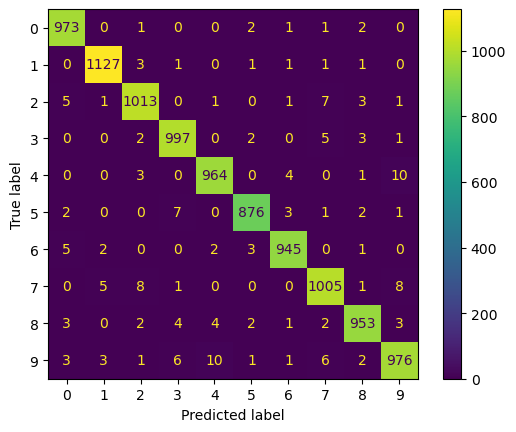

In [57]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_default)).plot()

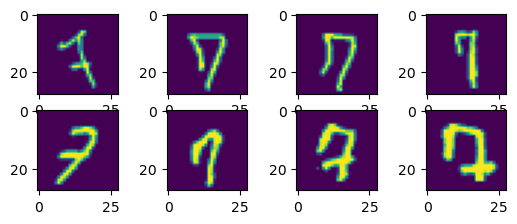

In [58]:
display_missed_predictions(y_pred_default, 7, 9)

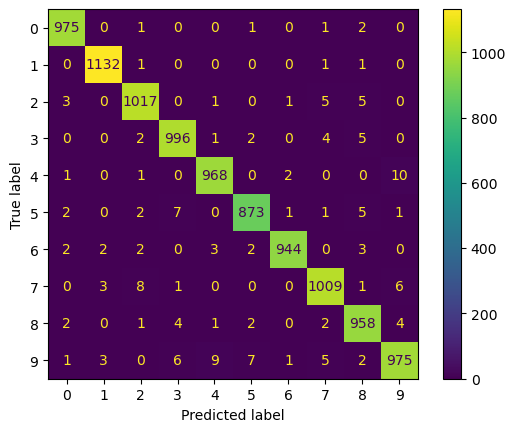

In [59]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_grid)).plot()

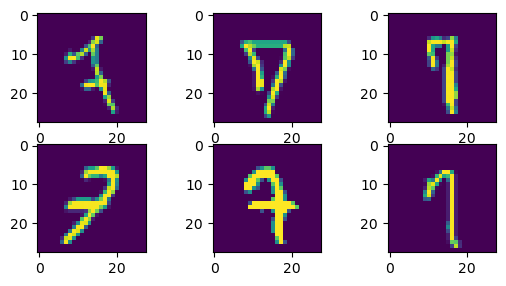

In [60]:
display_missed_predictions(y_pred_grid, 7, 9)